In [51]:
import pandas as pd
import dvc.api
import numpy as np
import matplotlib.pyplot as plt

In [52]:
df_test = pd.read_json(
    dvc.api.get_url(
        'data/mave_attr_extract/Mave_Title_GENRE_Test.json',
        repo='git@github.com:junwang-wish/query_understanding_data.git'
    ), lines=True
)

In [53]:
df_test.head(2)

,title,category,id,category_flat,title_attributes,text,label_pos_neg
0,Invicta Men's 80413 Subaqua Analog Display Swi...,"[clothing, shoes & jewelry, men, watches, wris...",B00IN5JM8K,Watches,"{'Watch Movement': [{'value': 'Quartz', 'pid':...",Invicta Men's 80413 Subaqua Analog Display Swi...,pos
1,Del Monte Cherry Mixed Fruit in Natural Fruit ...,"[grocery & gourmet food, canned, jarred & pack...",B0045G8KHA,Canned & Jarred Fruits,"{'Type': [{'value': 'Snack Cups', 'pid': 0, 'b...",Del Monte Cherry Mixed Fruit in Natural Fruit ...,pos


In [54]:
import sys 
sys.path.append('../..')

In [83]:
from main_utils import get_transformer
_, tokenizer = get_transformer('t5-base', False)

/opt/conda/envs/py38/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5_fast.py:156: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [55]:
from main_utils import LLMData 
LLMData('/workspaces/multitask-llm-rnd/modelling/datasets/product_title_attribute_extraction/mave_title_genre.yaml').hparams

/opt/conda/envs/py38/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5_fast.py:156: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


"batch_size":            16
"data_hash":             3867a981bab0a11f02900699b8bb7ea8
"data_source":           OrderedDict([('is_encoder_decoder', True), ('preprocess', OrderedDict([('transform', 'nothing')])), ('test', [{'path': 'data/mave_attr_extract/Mave_Title_GENRE_Test.json', 'repo': 'git@github.com:junwang-wish/query_understanding_data.git', 'rev': None, 'task_prefix': 'Attribute extraction for product: '}]), ('train', [{'path': 'data/mave_attr_extract/Mave_Title_GENRE_Train.json', 'repo': 'git@github.com:junwang-wish/query_understanding_data.git', 'rev': None, 'task_prefix': 'Attribute extraction for product: '}]), ('val', [{'path': 'data/mave_attr_extract/Mave_Title_GENRE_Val.json', 'repo': 'git@github.com:junwang-wish/query_understanding_data.git', 'rev': None, 'task_prefix': 'Attribute extraction for product: '}])])
"data_source_yaml_path": /workspaces/multitask-llm-rnd/modelling/datasets/product_title_attribute_extraction/mave_title_genre.yaml
"max_length":            250
"

In [56]:
!ls /data/junwang/.cache/general/3867a981bab0a11f02900699b8bb7ea8

test.json.gz  train.json.gz  val.json.gz


In [57]:
df_test_model = pd.read_json("/data/junwang/.cache/general/3867a981bab0a11f02900699b8bb7ea8/test.json.gz", lines=True)

In [58]:
assert len(df_test_model) == len(df_test)

In [59]:
df_test_model.head(2).to_dict('records')

[{'text_input': "Attribute extraction for product: Invicta Men's 80413 Subaqua Analog Display Swiss Quartz Black Watch",
  'text_output': "Invicta Men's 80413 Subaqua [Analog](Display) Display Swiss [Quartz](Watch Movement) Black Watch"},
 {'text_input': 'Attribute extraction for product: Del Monte Cherry Mixed Fruit in Natural Fruit Juice Snack Cups, 4 Cups, 4-Ounce Pack of 6',
  'text_output': 'Del Monte Cherry Mixed Fruit in Natural Fruit Juice [Snack Cups](Type), 4 [Cups](Type), 4-Ounce Pack of 6'}]

In [60]:
df_pred = pd.read_json("/workspaces/query_understanding_model/models/product_title_attribute_extraction/version_0/clm-epoch=4-step=23954--mave_title_genre.json", 
    lines=True)

In [61]:
df_pred = df_pred[df_pred.rank_indices == 0].sort_values('batch_indices')

In [62]:
assert len(df_pred) == len(df_test) == len(df_test_model)

In [64]:
df_pred['title'] = df_test['title'].tolist()

In [65]:
df_pred['prediction_target'] = df_test_model.text_output.tolist()

In [66]:
df_pred['category_flat'] = df_test['category_flat'].tolist()

In [67]:
df_pred['category'] = df_test['category'].tolist()

In [68]:
(df_pred.prediction_decoded == df_pred.prediction_target).mean()

0.6062206572769953

In [69]:
df_pred['title_attribute_target'] = df_test.title_attributes.tolist()

In [70]:
df_pred[['prediction_decoded', 'prediction_target', 'title_attribute_target']].sample(2).to_dict('records')

[{'prediction_decoded': 'Skyline Furniture Surrey California-King Micro-Suede-Upholstered Tufted Headboard, Black',
  'prediction_target': 'Skyline Furniture Surrey California-King Micro-Suede-Upholstered Tufted [Headboard](Type), Black',
  'title_attribute_target': {'Type': [{'value': 'Headboard',
     'pid': 0,
     'begin': 72,
     'end': 81}]}},
 {'prediction_decoded': 'Ri Pac Quart Slide Zipper Sandwich and Snack Bags - 250 Count - Food Storage for Kids Lunch',
  'prediction_target': 'Ri Pac Quart Slide [Zipper](Material) Sandwich and Snack Bags - [250 Count](Count) - Food Storage for Kids Lunch',
  'title_attribute_target': {'Material': [{'value': 'Zipper',
     'pid': 0,
     'begin': 19,
     'end': 25}],
   'Count': [{'value': '250 Count', 'pid': 0, 'begin': 52, 'end': 61}]}}]

In [71]:
text = 'Compaq EliteBook 8560p Laptop [Portable Charger](Type) - External Laptop [Battery Pack](Type) Dual USB [Power Bank](Type), 18000mAh, Multi-Voltage 5V 12V 16V 19V'

In [72]:
import re

In [73]:
def extract_attr_type_vals(text):
    regex = r"\[(.*?)\]\((.*?)\)"
    matches = [(m.group(2), m.group(1)) for m in re.finditer(regex, text.replace("\n", "").strip())]
    return matches

In [74]:
def extract_attr_type_vals_fromgroundtruth(i):
    res = []
    for t in i:
        for j in i[t]:
            res.append((t, j['value']))
    return res

In [75]:
df_pred['title_attribute_pred'] = df_pred['prediction_decoded'].apply(extract_attr_type_vals)

In [76]:
df_pred['title_attribute_target_processed'] = df_pred['title_attribute_target'].apply(extract_attr_type_vals_fromgroundtruth)
df_pred['title_attribute_target_processed_manual'] = df_pred['prediction_target'].apply(extract_attr_type_vals)

In [77]:
(df_pred.title_attribute_target_processed.apply(set) == df_pred.title_attribute_target_processed_manual.apply(set)).all()

False

In [78]:
df_pred_clean = df_pred[df_pred.title_attribute_target_processed.apply(set) == df_pred.title_attribute_target_processed_manual.apply(set)]

In [79]:
len(df_pred_clean) / len(df_pred)

0.999706572769953

In [82]:
def tokenize_with_map(text, tokenizer):
    res = tokenizer(text, return_offsets_mapping=True, add_special_tokens=False)
    return tokenizer.convert_ids_to_tokens(res['input_ids']), res['offset_mapping']

In [84]:
from functools import partial

In [85]:
df_pred_clean['title_tokens_with_map'] = df_pred_clean['title'].apply(partial(tokenize_with_map, tokenizer=tokenizer))

/tmp/ipykernel_79993/3555531946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_clean['title_tokens_with_map'] = df_pred_clean['title'].apply(partial(tokenize_with_map, tokenizer=tokenizer))


In [94]:
from copy import deepcopy

In [104]:
# ground truth
recs = []
for i in df_pred_clean.to_dict('records'):
    # https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)
    iob2_ner_tags = ["O" for _ in range(len(i['title_tokens_with_map'][0]))]
    c_text = i['category_flat'].replace(' ', '-')
    for a in i['title_attribute_target']:
        a_text = a.replace(' ', '-')
        for v in i['title_attribute_target'][a]:
            b, e = v['begin'], v['end']
            tok_mode = "B"
            for ind, (tok_b, tok_e) in enumerate(i['title_tokens_with_map'][1]):
                if tok_b <= b < tok_e or b <= tok_b < e or tok_b <= e-1 < tok_e or b <= tok_e-1 < e:
                    iob2_ner_tags[ind] = f"{tok_mode}-{c_text}-{a_text}"
                    if tok_mode == "B":
                        tok_mode = "I"
    i['iob2_ner_tags'] = deepcopy(iob2_ner_tags)

    iob2_ner_tags = ["O" for _ in range(len(i['title_tokens_with_map'][0]))]
    c_text = i['category_flat'].replace(' ', '-')
    for a in i['title_attribute_target']:
        a_text = a.replace(' ', '-')
        for v in i['title_attribute_target'][a]:
            if (a, v['value']) in i['title_attribute_pred']:
                b, e = v['begin'], v['end']
                tok_mode = "B"
                for ind, (tok_b, tok_e) in enumerate(i['title_tokens_with_map'][1]):
                    if tok_b <= b < tok_e or b <= tok_b < e or tok_b <= e-1 < tok_e or b <= tok_e-1 < e:
                        iob2_ner_tags[ind] = f"{tok_mode}-{c_text}-{a_text}"
                        if tok_mode == "B":
                            tok_mode = "I"
    i['iob2_ner_tags_pred'] = deepcopy(iob2_ner_tags)
    recs.append(i)

df_pred_clean = pd.DataFrame(recs)

In [105]:
df_pred_clean_empty = df_pred_clean[df_pred_clean.title_attribute_target_processed.apply(len) == 0]

In [106]:
df_pred_clean_empty[df_pred_clean_empty.category_flat == "Stuffed Animals"].sample(2).to_dict('records')

[{'prediction_decoded': 'Aurora World YooHoo and Friends Small Pammee Hot Pink Cheetah Plush',
  'batch_idx': 446,
  'dataloader_idx': 0,
  'batch_indices': 7148,
  'rank_indices': 0,
  'title': 'Aurora World YooHoo and Friends Small Pammee Hot Pink Cheetah Plush',
  'prediction_target': 'Aurora World YooHoo and Friends Small Pammee Hot Pink Cheetah Plush',
  'category_flat': 'Stuffed Animals',
  'category': ['toys & games',
   'stuffed animals & plush toys',
   'stuffed animals & teddy bears'],
  'title_attribute_target': {'Form': []},
  'title_attribute_pred': [],
  'title_attribute_target_processed': [],
  'title_attribute_target_processed_manual': [],
  'title_tokens_with_map': (['▁Aurora',
    '▁World',
    '▁Yo',
    'o',
    'Ho',
    'o',
    '▁and',
    '▁Friends',
    '▁Small',
    '▁Pam',
    'me',
    'e',
    '▁Hot',
    '▁Pink',
    '▁Che',
    'e',
    't',
    'a',
    'h',
    '▁Plus',
    'h'],
   [(0, 6),
    (7, 12),
    (13, 15),
    (15, 16),
    (16, 18),
    (18

In [107]:
df_pred_clean_nonempty = df_pred_clean[df_pred_clean.title_attribute_target_processed.apply(len) > 0]

In [108]:
jiccards = []
for i in df_pred_clean.to_dict('records'):
    pred_set = set(i['title_attribute_pred'])
    target_set = set(i['title_attribute_target_processed'])
    if len(target_set) == 0:
        if len(pred_set) != 0:
            jiccards.append(0)
        else:
            jiccards.append(1)
    else:
        jiccards.append(len(pred_set.intersection(target_set)) / len(pred_set.union(target_set)))

In [109]:
np.mean(jiccards)

0.6856439356879628

(array([2.943e+03, 0.000e+00, 1.100e+01, 7.100e+01, 3.000e+00, 3.900e+02,
        4.800e+01, 7.000e+00, 0.000e+00, 6.748e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

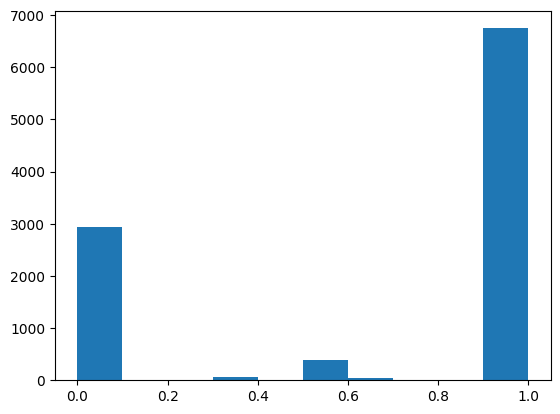

In [110]:
plt.hist(jiccards)

mean jaccard:  0.5638063325563325


(array([2.724e+03, 0.000e+00, 1.100e+01, 7.100e+01, 3.000e+00, 3.900e+02,
        4.800e+01, 7.000e+00, 0.000e+00, 3.610e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

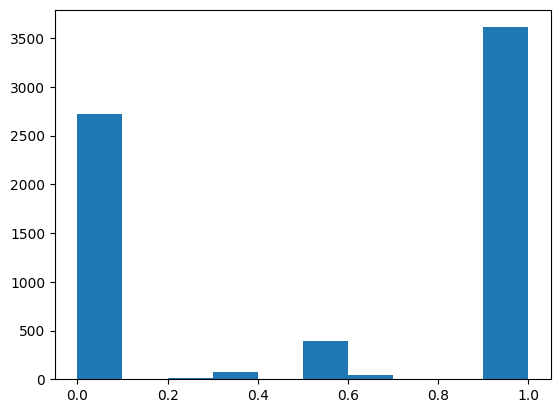

In [111]:
jiccards = []
for i in df_pred_clean_nonempty.to_dict('records'):
    pred_set = set(i['title_attribute_pred'])
    target_set = set(i['title_attribute_target_processed'])
    if len(target_set) == 0:
        if len(pred_set) != 0:
            jiccards.append(0)
        else:
            jiccards.append(1)
    else:
        jiccards.append(len(pred_set.intersection(target_set)) / len(pred_set.union(target_set)))
print("mean jaccard: ", np.mean(jiccards))
plt.hist(jiccards)

In [112]:
tmp = df_pred_clean

In [113]:
df_pred_clean_nonempty[df_pred_clean_nonempty.title_attribute_target.apply(len) \
    > df_pred_clean_nonempty.title_attribute_target_processed.apply(len)].head(1).to_dict('records')

[]

In [114]:
df_pred_clean_nonempty[df_pred_clean_nonempty.title_attribute_target.apply(len) \
    == df_pred_clean_nonempty.title_attribute_target_processed.apply(len)].head(1).to_dict('records')

[{'prediction_decoded': "Invicta Men's 80413 Subaqua [Analog](Display) Display Swiss [Quartz](Watch Movement) Black Watch",
  'batch_idx': 0,
  'dataloader_idx': 0,
  'batch_indices': 0,
  'rank_indices': 0,
  'title': "Invicta Men's 80413 Subaqua Analog Display Swiss Quartz Black Watch",
  'prediction_target': "Invicta Men's 80413 Subaqua [Analog](Display) Display Swiss [Quartz](Watch Movement) Black Watch",
  'category_flat': 'Watches',
  'category': ['clothing, shoes & jewelry',
   'men',
   'watches',
   'wrist watches',
   'swiss quartz movement'],
  'title_attribute_target': {'Watch Movement': [{'value': 'Quartz',
     'pid': 0,
     'begin': 49,
     'end': 55}],
   'Display': [{'value': 'Analog', 'pid': 0, 'begin': 28, 'end': 34}]},
  'title_attribute_pred': [('Display', 'Analog'),
   ('Watch Movement', 'Quartz')],
  'title_attribute_target_processed': [('Watch Movement', 'Quartz'),
   ('Display', 'Analog')],
  'title_attribute_target_processed_manual': [('Display', 'Analog'),


In [115]:
df_pred_clean_nonempty[df_pred_clean_nonempty.title_attribute_target.apply(len) \
    < df_pred_clean_nonempty.title_attribute_target_processed.apply(len)].head(1).to_dict('records')

[{'prediction_decoded': 'Del Monte Cherry Mixed Fruit in Natural Fruit Juice Snack Cups, 4 Cups, 4-Ounce Pack of 6',
  'batch_idx': 0,
  'dataloader_idx': 0,
  'batch_indices': 1,
  'rank_indices': 0,
  'title': 'Del Monte Cherry Mixed Fruit in Natural Fruit Juice Snack Cups, 4 Cups, 4-Ounce (Pack of 6)',
  'prediction_target': 'Del Monte Cherry Mixed Fruit in Natural Fruit Juice [Snack Cups](Type), 4 [Cups](Type), 4-Ounce Pack of 6',
  'category_flat': 'Canned & Jarred Fruits',
  'category': ['grocery & gourmet food',
   'canned, jarred & packaged foods',
   'fruits'],
  'title_attribute_target': {'Type': [{'value': 'Snack Cups',
     'pid': 0,
     'begin': 52,
     'end': 62},
    {'value': 'Cups', 'pid': 0, 'begin': 66, 'end': 70}]},
  'title_attribute_pred': [],
  'title_attribute_target_processed': [('Type', 'Snack Cups'),
   ('Type', 'Cups')],
  'title_attribute_target_processed_manual': [('Type', 'Snack Cups'),
   ('Type', 'Cups')],
  'title_tokens_with_map': (['▁Del',
    '▁Mo

In [116]:
df_pred_clean_empty[df_pred_clean_empty.title_attribute_target.apply(len) \
    > df_pred_clean_empty.title_attribute_target_processed.apply(len)].head(1).to_dict('records')

[{'prediction_decoded': 'Sensible Portions Chip Garden Veggie Sea Salt, 5 oz',
  'batch_idx': 0,
  'dataloader_idx': 0,
  'batch_indices': 3,
  'rank_indices': 0,
  'title': 'Sensible Portions Chip Garden Veggie Sea Salt, 5 oz',
  'prediction_target': 'Sensible Portions Chip Garden Veggie Sea Salt, 5 oz',
  'category_flat': 'Chips',
  'category': ['grocery & gourmet food', 'snack foods', 'chips & crisps'],
  'title_attribute_target': {'Fat Content': [], 'Sugar Content': []},
  'title_attribute_pred': [],
  'title_attribute_target_processed': [],
  'title_attribute_target_processed_manual': [],
  'title_tokens_with_map': (['▁Sen',
    's',
    'ible',
    '▁Port',
    'ions',
    '▁Chip',
    '▁Garden',
    '▁',
    'Veg',
    'gie',
    '▁Sea',
    '▁Salt',
    ',',
    '▁5',
    '▁',
    'o',
    'z'],
   [(0, 3),
    (3, 4),
    (4, 8),
    (9, 13),
    (13, 17),
    (18, 22),
    (23, 29),
    (30, 31),
    (30, 33),
    (33, 36),
    (37, 40),
    (41, 45),
    (45, 46),
    (47, 4

In [117]:
df_pred_clean_empty[df_pred_clean_empty.title_attribute_target.apply(len) \
    == df_pred_clean_empty.title_attribute_target_processed.apply(len)].head(1).to_dict('records')

[]

In [118]:
df_pred_clean_empty[df_pred_clean_empty.title_attribute_target.apply(len) \
    < df_pred_clean_empty.title_attribute_target_processed.apply(len)].head(1).to_dict('records')

[]

In [119]:
tmp = df_pred_clean

In [120]:
from pprint import pprint

In [121]:
pprint(
    df_pred_clean_empty[['prediction_decoded', 'prediction_target', 'title_attribute_target_processed', 
        'title_attribute_pred', 'title_attribute_target', 'category_flat']].head(1).to_dict('records')[0]
)

{'category_flat': 'Chips',
 'prediction_decoded': 'Sensible Portions Chip Garden Veggie Sea Salt, 5 oz',
 'prediction_target': 'Sensible Portions Chip Garden Veggie Sea Salt, 5 oz',
 'title_attribute_pred': [],
 'title_attribute_target': {'Fat Content': [], 'Sugar Content': []},
 'title_attribute_target_processed': []}


In [122]:
pprint(
    df_pred_clean_nonempty[['prediction_decoded', 'prediction_target', 'title_attribute_target_processed', 
        'title_attribute_pred', 'title_attribute_target', 'category_flat']].head(1).to_dict('records')[0]
)

{'category_flat': 'Watches',
 'prediction_decoded': "Invicta Men's 80413 Subaqua [Analog](Display) Display "
                       'Swiss [Quartz](Watch Movement) Black Watch',
 'prediction_target': "Invicta Men's 80413 Subaqua [Analog](Display) Display "
                      'Swiss [Quartz](Watch Movement) Black Watch',
 'title_attribute_pred': [('Display', 'Analog'), ('Watch Movement', 'Quartz')],
 'title_attribute_target': {'Display': [{'begin': 28,
                                         'end': 34,
                                         'pid': 0,
                                         'value': 'Analog'}],
                            'Watch Movement': [{'begin': 49,
                                                'end': 55,
                                                'pid': 0,
                                                'value': 'Quartz'}]},
 'title_attribute_target_processed': [('Watch Movement', 'Quartz'),
                                      ('Display', 'Analog')]

In [123]:
from collections import defaultdict

In [124]:
from tqdm import tqdm

In [125]:
total_match_tracker = {'VC': 0, 'VW': 0, 'VN': 0, 'NV': 0, 'NN': 0, 'support': 0}
per_att_match_tracker = defaultdict(lambda: {'VC': 0, 'VW': 0, 'VN': 0, 'NV': 0, 'NN': 0, 'support': 0})
per_sample_match_tracker = defaultdict(lambda: {'VC': 0, 'VW': 0, 'VN': 0, 'NV': 0, 'NN': 0, 'support': 0})

In [126]:
def update_match(d, VC, VW, VN, NV, NN, support):
    d['VC'] += VC
    d['VW'] += VW
    d['VN'] += VN
    d['NV'] += NV
    d['NN'] += NN
    d['support'] += support

In [127]:
def p_r_f1(VC=0, VW=0, VN=0, NV=0, NN=0, support=None, uid=None):
    ## Types of matches between target and prediction is formated as TargetType-PredType

    # VC: Value-Correct, VW: Value-Wrong, VN: Value-Null
    # NV: Null-Value, NN: Null-Null

    ## How to calculate precision / recall / F1

    # P (Positive) = VC + VW + VN
    # PP (Predicted Positive) = VC + VW + NV
    # Recall = TP / P = VC / (VC + VW + VN)
    # Precision = TP / PP = VC / (VC + VW + NV)
    # F1 (Sørensen–Dice coefficient between Precision and Recall) = 2 * Precision * Recall / (Precision + Recall)
    p = VC / (VC + VW + NV + 1e-8)
    r = VC / (VC + VW + VN + 1e-8)
    f1 = 2 * p * r / (p + r + 1e-8)
    acc = (VC + NN) / (VC + NN + VW + VN + NV + 1e-8)
    return {'uid': uid, 'precision': p, 'recall': r, 'f1': f1, 'support': support, 'acc': acc, 'VC': VC, 'VW': VW, 'VN': VN, 'NV': NV, 'NN': NN}

In [128]:
tmp = pd.concat([df_pred_clean_empty, df_pred_clean_nonempty])
for ind, i in tqdm(enumerate(tmp.to_dict('records'))):
    ## put val or multiple vals for each att for each sample into dict[set] for easy comparison
    target = {}
    for att, val in i['title_attribute_target_processed']:
        if att not in target:
            target[att] = set()
        target[att].add(val)
    pred = {}
    for att, val in i['title_attribute_pred']:
        if att not in pred:
            pred[att] = set()
        pred[att].add(val)
        
    VC, VW, VN = 0, 0, 0
    NV, NN = 0, 0
    
    for att in i['title_attribute_target']:
        if att in target:
            if att in pred:
                # set(vals) == set(vals) for each att is a high bar to reach, but this upperbounds our performance
                # Jaccard could be used for a soft match, but open problem how to normalize numbers to get well-behaved P/R/F1
                if target[att] == pred[att]:
                    # target_nonempty_pred_nonempty_correct (VC, i.e. TP)
                    VC += 1
                else:
                    # target_nonempty_pred_nonempty_incorrect (VW, i.e. FP)
                    VW += 1
            else:
                # target_nonempty_pred_empty_incorrect (VN, i.e. FN)
                VN += 1
        else:
            if att in pred:
                # target_empty_pred_nonempty_incorrect (NV, i.e. FP)
                NV += 1
            else:
                # target_empty_pred_empty_correct (NN, i.e. TN)
                NN += 1
        update_match(per_att_match_tracker[(i['category_flat'], att)], VC, VW, VN, NV, NN, 1)
    update_match(total_match_tracker, VC, VW, VN, NV, NN, 1)
    update_match(per_sample_match_tracker[ind], VC, VW, VN, NV, NN, 1)

10221it [00:00, 152915.93it/s]


In [129]:
# micro avgeraging (total count)
p_r_f1(**total_match_tracker)

{'uid': None,
 'precision': 0.947524962819317,
 'recall': 0.5467026231912887,
 'f1': 0.6933540567656229,
 'support': 10221,
 'acc': 0.7133007978923903,
 'VC': 4460,
 'VW': 244,
 'VN': 3454,
 'NV': 3,
 'NN': 4748}

In [130]:
df_per_att_match = pd.DataFrame([p_r_f1(uid=uid, **per_att_match_tracker[uid]) for uid in per_att_match_tracker])

In [131]:
df_per_sample_match = pd.DataFrame([p_r_f1(uid=uid, **per_sample_match_tracker[uid]) for uid in per_sample_match_tracker])

In [132]:
# weight-by-support avgeraging
(df_per_att_match.f1 * df_per_att_match.support).sum() / df_per_att_match.support.sum(), \
    (df_per_att_match.acc * df_per_att_match.support).sum() / df_per_att_match.support.sum()

(0.4698256682478228, 0.7172970012578697)

In [133]:
# macro averaging (equal weight for each attribute)
df_per_att_match.f1.mean(), df_per_att_match.acc.mean()

(0.1244166974568072, 0.5484693043515005)

In [134]:
# instance averaging (equal weight for each sample)
df_per_sample_match.f1.mean(), df_per_sample_match.acc.mean()

(0.38021929094616247, 0.7032840820839957)

In [135]:
df_per_att_match[df_per_att_match.f1 > 0.9]

,uid,precision,recall,f1,support,acc,VC,VW,VN,NV,NN
14,"(Shirts & Tops, Shoulder Style)",1.000000,1.000000,1.000000,23,1.000000,2,0,0,0,22
65,"(Shoes, Heel Style)",1.000000,0.853846,0.921162,103,0.867133,111,0,19,0,13
68,"(Shoes, Type)",0.981027,0.881645,0.928685,853,0.884314,879,17,101,0,23
70,"(Robes, Pattern)",1.000000,1.000000,1.000000,8,1.000000,1,0,0,0,7
73,"(Costumes, Size Type)",0.888889,1.000000,0.941176,25,0.964286,8,0,0,1,19
74,"(Watches, Mechanical Movement)",1.000000,1.000000,1.000000,48,1.000000,35,0,0,0,23
84,"(Watches, Watch Movement)",0.989529,0.969231,0.979275,178,0.972603,189,2,4,0,24
95,"(Underwear, Pattern)",1.000000,1.000000,1.000000,6,1.000000,3,0,0,0,4
104,"(Motor Vehicle Engine Parts, Gasket Type)",1.000000,0.875000,0.933333,15,0.933333,7,0,1,0,7
120,"(Watches, Style)",1.000000,0.909091,0.952381,19,0.954545,10,0,1,0,11


In [136]:
df_per_att_match[df_per_att_match.f1 < 0.1].sort_values('support', ascending=False)

,uid,precision,recall,f1,support,acc,VC,VW,VN,NV,NN
62,"(Games, Maximum Players)",0.0,0.0,0.0,34,1.000000,0,0,0,0,69
140,"(Home & Garden, Location)",0.0,0.0,0.0,32,0.947368,0,0,2,0,36
61,"(Games, Play Time)",0.0,0.0,0.0,31,1.000000,0,0,0,0,67
189,"(Games, Recommended Age)",0.0,0.0,0.0,30,1.000000,0,0,0,0,62
108,"(Video Game Software, ESRB Rating)",0.0,0.0,0.0,30,1.000000,0,0,0,0,30
...,...,...,...,...,...,...,...,...,...,...,...
876,"(Juice, Fresh / Frozen)",0.0,0.0,0.0,1,1.000000,0,0,0,0,2
875,"(Juice, Sugar Content)",0.0,0.0,0.0,1,1.000000,0,0,0,0,1
874,"(Wreaths & Garlands, Special Occasion)",0.0,0.0,0.0,1,1.000000,0,0,0,0,1
871,"(Patio Heaters, Power Type)",0.0,0.0,0.0,1,1.000000,0,0,0,0,1


# CoNLL-2000 eval method

In [142]:
from seqeval.metrics import classification_report, accuracy_score

In [143]:

y_true = df_pred_clean['iob2_ner_tags'].tolist()
y_pred = df_pred_clean['iob2_ner_tags_pred'].tolist()


In [144]:
accuracy_score(y_true, y_pred)

0.9527340347903868

In [145]:
print(classification_report(y_true, y_pred))

/opt/conda/envs/py38/lib/python3.8/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                          precision    recall  f1-score   support

           3D-Printer-Accessories-Printing-Material-Type       1.00      1.00      1.00         6
                           Accordions-&-Concertinas-Type       0.00      0.00      0.00         1
                        Action-&-Toy-Figures-Figure-Type       1.00      0.86      0.92        49
                              Action-&-Toy-Figures-Theme       1.00      0.54      0.70        13
                               Action-&-Toy-Figures-Type       0.00      0.00      0.00         1
                       Activity-Monitor-Accessories-Type       1.00      0.46      0.63        13
                       Air-Conditioners-Cooling-Capacity       0.00      0.00      0.00         4
                           Air-Conditioners-Installation       0.00      0.00      0.00         4
                                     Air-Mattresses-Size       0.00      0.00      0.00         1
                   

In [140]:
print(classification_report([["B-SIZE", "B-COLOR", "O"]], [["B-SIZE", "O", "O"]]))

              precision    recall  f1-score   support

       COLOR       0.00      0.00      0.00         1
        SIZE       1.00      1.00      1.00         1

   micro avg       1.00      0.50      0.67         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [141]:
print(classification_report([["B-SIZE", "B-COLOR", "O"]], [["B-SIZE", "B-STYLE", "O"]]) )

              precision    recall  f1-score   support

       COLOR       0.00      0.00      0.00         1
        SIZE       1.00      1.00      1.00         1
       STYLE       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50         2
   macro avg       0.33      0.33      0.33         2
weighted avg       0.50      0.50      0.50         2

